In [1]:
!pip install pandas torch transformers datasets scikit-learn peft accelerate matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import pandas as pd
import torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig
import warnings

# Ignore harmless warnings
warnings.filterwarnings("ignore")

# --- Configuration ---
MODEL_NAME = "distilbert-base-uncased"
DATA_PATH = "processed_binary_dga_dataset.csv" # The name of your uploaded 3M+ row dataset
SAMPLE_SIZE = 200000

In [3]:
# --- Step 1: Load and Create a Balanced Sample ---
print("--- Preparing Data ---")

# Load the full dataset
print(f"Loading full dataset from: {DATA_PATH}")
df = pd.read_csv(DATA_PATH)

# Create a balanced sample
sample_per_class = SAMPLE_SIZE // 2
print(f"Creating a balanced sample of {SAMPLE_SIZE} domains...")
benign_sample = df[df['label'] == 0].sample(n=sample_per_class, random_state=42)
malicious_sample = df[df['label'] == 1].sample(n=sample_per_class, random_state=42)
sampled_df = pd.concat([benign_sample, malicious_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Sampled dataset created with {len(sampled_df)} rows.")
print("Label distribution in sample:")
print(sampled_df['label'].value_counts())

--- Preparing Data ---
Loading full dataset from: processed_binary_dga_dataset.csv
Creating a balanced sample of 200000 domains...
Sampled dataset created with 200000 rows.
Label distribution in sample:
label
1    100000
0    100000
Name: count, dtype: int64


In [4]:
# --- Step 2: Split the Data ---
print("Splitting data into training, validation, and test sets...")

# Split the data (30% train, 20% validation, 50% test)
train_df, temp_df = train_test_split(sampled_df, test_size=0.7, stratify=sampled_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.714, stratify=temp_df['label'], random_state=42)

# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

print(f"Training set: {len(train_dataset)} | Validation set: {len(val_dataset)} | Test set: {len(test_dataset)}")

Splitting data into training, validation, and test sets...
Training set: 60000 | Validation set: 40040 | Test set: 99960


In [5]:
# --- Step 3: Tokenize the Data ---
print(f"Tokenizing Data for {MODEL_NAME}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples['domain'], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

print("Tokenization complete.")

Tokenizing Data for distilbert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40040 [00:00<?, ? examples/s]

Map:   0%|          | 0/99960 [00:00<?, ? examples/s]

Tokenization complete.


In [7]:
# --- Step 4: Load Model and Apply LoRA ---
print(f"Loading model '{MODEL_NAME}' and applying LoRA...")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
lora_config = LoraConfig(r=8, lora_alpha=16, target_modules= ["q_lin", "v_lin"], lora_dropout=0.1, bias="none", task_type="SEQ_CLS")
model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

Loading model 'distilbert-base-uncased' and applying LoRA...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


In [9]:
# --- Step 5: Train the Model ---
print("Starting model training... 🚀")

training_args = TrainingArguments(
    output_dir=f"./results_{MODEL_NAME}",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

trainer.train()

print("✅ Training complete!")

Starting model training... 🚀


Epoch,Training Loss,Validation Loss
1,0.118700,0.112466


✅ Training complete!


Evaluating model on the test set...



Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      0.96      0.96     49980
Malicious (1)       0.96      0.96      0.96     49980

     accuracy                           0.96     99960
    macro avg       0.96      0.96      0.96     99960
 weighted avg       0.96      0.96      0.96     99960



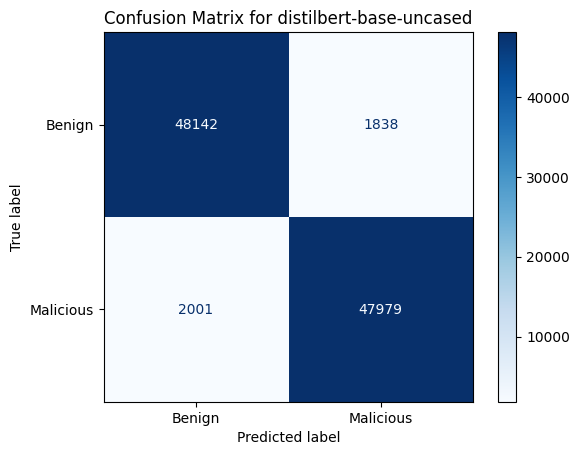


✅ Results saved as 'classification_report.txt' and 'confusion_matrix.png'


In [10]:
# --- Step 6: Final Evaluation and Saving Results ---
print("Evaluating model on the test set...")

predictions = trainer.predict(tokenized_test)
predicted_labels = torch.argmax(torch.from_numpy(predictions.predictions), dim=-1).numpy()
true_labels = [item['label'] for item in test_dataset]

# Save Classification Report
report = classification_report(
    true_labels,
    predicted_labels,
    target_names=['Benign (0)', 'Malicious (1)']
)
with open("classification_report.txt", "w") as f:
    f.write(report)

print("\nClassification Report:")
print(report)

# Save Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    true_labels,
    predicted_labels,
    display_labels=['Benign', 'Malicious'],
    cmap='Blues'
)
plt.title(f"Confusion Matrix for {MODEL_NAME}")
plt.savefig("confusion_matrix.png")
plt.show()

print("\n✅ Results saved as 'classification_report.txt' and 'confusion_matrix.png'")

In [11]:
# --- Step 7: Package Model for Download ---
output_dir = f"./results_{MODEL_NAME}"
!zip -r fine_tuned_model.zip {output_dir}

print(f"✅ Model saved in '{output_dir}' has been zipped to 'fine_tuned_model.zip'.")
print("You can now download it from the file explorer on the left.")

  adding: results_distilbert-base-uncased/ (stored 0%)
  adding: results_distilbert-base-uncased/checkpoint-1875/ (stored 0%)
  adding: results_distilbert-base-uncased/checkpoint-1875/trainer_state.json (deflated 62%)
  adding: results_distilbert-base-uncased/checkpoint-1875/adapter_config.json (deflated 56%)
  adding: results_distilbert-base-uncased/checkpoint-1875/README.md (deflated 66%)
  adding: results_distilbert-base-uncased/checkpoint-1875/training_args.bin (deflated 52%)
  adding: results_distilbert-base-uncased/checkpoint-1875/optimizer.pt (deflated 7%)
  adding: results_distilbert-base-uncased/checkpoint-1875/adapter_model.safetensors (deflated 7%)
  adding: results_distilbert-base-uncased/checkpoint-1875/scheduler.pt (deflated 56%)
  adding: results_distilbert-base-uncased/checkpoint-1875/rng_state.pth (deflated 25%)
✅ Model saved in './results_distilbert-base-uncased' has been zipped to 'fine_tuned_model.zip'.
You can now download it from the file explorer on the left.
